In [ ]:
!pip install --upgrade "ultralytics[full]" opencv-python tqdm


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 116.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 85.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 60.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 23.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 103.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 54.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstallin

In [ ]:
import cv2
import torch
from ultralytics import YOLO
from pathlib import Path


device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Running on: {device}")

model = YOLO("yolov8x.pt").to(device)

model.classes = [32]

model.conf = 0.25
model.iou = 0.45

print("Model loaded. Ready to detect COCO class 32 (sports ball).")


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Running on: cuda


100%|██████████| 131M/131M [00:00<00:00, 262MB/s]


Model loaded. Ready to detect COCO class 32 (sports ball).


In [ ]:
import cv2
from google.colab import files


input_path = "/content/5G3XWICS8NS4.mp4"
output_path = "annotated_cropped_output.mp4"
cap = cv2.VideoCapture(str(input_path))
if not cap.isOpened():
    raise RuntimeError(f"Could not open video {input_path}")

fps    = cap.get(cv2.CAP_PROP_FPS)
orig_w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
orig_h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
new_h  = int(orig_h * 0.8)  # keep top 80%
fourcc = cv2.VideoWriter_fourcc(*"mp4v")
writer = cv2.VideoWriter(output_path, fourcc, fps, (orig_w, new_h))

print(f"Annotating top 80% of frames (cropped height={new_h}) and saving to {output_path}...")
frame_idx = 0

while True:
    ret, frame_bgr = cap.read()
    if not ret:
        break
    frame_idx += 1

    cropped = frame_bgr[0:new_h, :]

    frame_rgb = cv2.cvtColor(cropped, cv2.COLOR_BGR2RGB)
    results = model.predict(
        source=frame_rgb,
        imgsz=1280,
        conf=model.conf,
        device=device,
        save=False,
        verbose=False
    )

    if len(results) == 0 or len(results[0].boxes) == 0:
        writer.write(cropped)
        continue

    boxes = results[0].boxes.xyxy.cpu().numpy()
    cls_np = results[0].boxes.cls.cpu().numpy()
    confs  = results[0].boxes.conf.cpu().numpy()

    for i, cls_id in enumerate(cls_np):
        if int(cls_id) != 32:
            continue
        x1, y1, x2, y2 = boxes[i].astype(int).tolist()
        cx = int((x1 + x2) / 2)
        cy = int((y1 + y2) / 2)

        # Draw green bounding box on cropped frame
        cv2.rectangle(cropped, (x1, y1), (x2, y2), (0, 255, 0), 2)
        # Draw red centroid
        cv2.circle(cropped, (cx, cy), 5, (0, 0, 255), -1)

        label = f"ball {confs[i]:.2f}"
        cv2.putText(
            cropped,
            label,
            (x1, y1 - 10),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.6,
            (0, 255, 0),
            2
        )

    writer.write(cropped)

cap.release()
writer.release()
print("Annotation and cropping complete. Saved to annotated_cropped_output.mp4")


RuntimeError: Could not open video /content/5G3XWICS8NS4.mp4

In [ ]:
import cv2
from google.colab import files

input_path = "/content/1TUIFHZRU2N0.mp4"


output_path = "annotated_cropped_clahe_output.mp4"
cap = cv2.VideoCapture(str(input_path))
if not cap.isOpened():
    raise RuntimeError(f"Could not open video {input_path}")

fps    = cap.get(cv2.CAP_PROP_FPS)
orig_w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
orig_h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
new_h  = int(orig_h * 0.8)  # keep top 80%
fourcc = cv2.VideoWriter_fourcc(*"mp4v")
writer = cv2.VideoWriter(output_path, fourcc, fps, (orig_w, new_h))

clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))

print(f"Processing video: cropping bottom 20%, applying CLAHE, saving to {output_path}...")
frame_idx = 0

while True:
    ret, frame_bgr = cap.read()
    if not ret:
        break
    frame_idx += 1

    cropped = frame_bgr[0:new_h, :]

    gray = cv2.cvtColor(cropped, cv2.COLOR_BGR2GRAY)

    enhanced = clahe.apply(gray)
    enhanced_bgr = cv2.cvtColor(enhanced, cv2.COLOR_GRAY2BGR)

    # Run YOLOv8 on the enhanced cropped frame
    frame_rgb = cv2.cvtColor(enhanced_bgr, cv2.COLOR_BGR2RGB)
    results = model.predict(
        source=frame_rgb,
        imgsz=1280,
        conf=model.conf,
        device=device,
        save=False,
        verbose=False
    )

    # If no detection, write enhanced cropped frame unmodified
    if len(results) == 0 or len(results[0].boxes) == 0:
        writer.write(enhanced_bgr)
        continue

    # Extract bounding boxes, class IDs, confidences
    boxes = results[0].boxes.xyxy.cpu().numpy()
    cls_np = results[0].boxes.cls.cpu().numpy()
    confs  = results[0].boxes.conf.cpu().numpy()

    # Draw only for COCO class 32 (sports ball)
    for i, cls_id in enumerate(cls_np):
        if int(cls_id) != 32:
            continue
        x1, y1, x2, y2 = boxes[i].astype(int).tolist()
        cx = int((x1 + x2) / 2)
        cy = int((y1 + y2) / 2)

        # Draw green bounding box on enhanced cropped frame
        cv2.rectangle(enhanced_bgr, (x1, y1), (x2, y2), (0, 255, 0), 2)
        # Draw red centroid
        cv2.circle(enhanced_bgr, (cx, cy), 5, (0, 0, 255), -1)

        label = f"ball {confs[i]:.2f}"
        cv2.putText(
            enhanced_bgr,
            label,
            (x1, y1 - 10),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.6,
            (0, 255, 0),
            2
        )

    writer.write(enhanced_bgr)

cap.release()
writer.release()
print("Cropping + CLAHE processing and annotation complete.")


Processing video: cropping bottom 20%, applying CLAHE, saving to annotated_cropped_clahe_output.mp4...
Cropping + CLAHE processing and annotation complete.


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from scipy.spatial.distance import cdist
import pandas as pd

class BallTracker:

    def __init__(self, max_distance=50, min_track_length=5):
        self.max_distance = max_distance
        self.min_track_length = min_track_length
        self.tracks = {}
        self.next_track_id = 0
        self.active_tracks = {}

    def update(self, frame_idx, detections):
        if not detections:
            # No detections, mark tracks as inactive
            self.active_tracks.clear()
            return

        if not self.active_tracks:
            for x, y, conf in detections:
                track_id = self.next_track_id
                self.tracks[track_id] = [(frame_idx, x, y, conf)]
                self.active_tracks[track_id] = (x, y)
                self.next_track_id += 1
        else:
            track_ids = list(self.active_tracks.keys())
            track_positions = np.array([self.active_tracks[tid] for tid in track_ids])
            detection_positions = np.array([(x, y) for x, y, _ in detections])

            distances = cdist(track_positions, detection_positions)

            matched_tracks = set()
            matched_detections = set()

            for _ in range(min(len(track_ids), len(detections))):
                if distances.size == 0:
                    break

                min_idx = np.unravel_index(distances.argmin(), distances.shape)
                track_idx, det_idx = min_idx

                if distances[track_idx, det_idx] <= self.max_distance:
                    track_id = track_ids[track_idx]
                    x, y, conf = detections[det_idx]
                    self.tracks[track_id].append((frame_idx, x, y, conf))
                    self.active_tracks[track_id] = (x, y)
                    matched_tracks.add(track_idx)
                    matched_detections.add(det_idx)

                distances[track_idx, :] = np.inf
                distances[:, det_idx] = np.inf

            for i, track_id in enumerate(track_ids):
                if i not in matched_tracks:
                    del self.active_tracks[track_id]

            for i, (x, y, conf) in enumerate(detections):
                if i not in matched_detections:
                    track_id = self.next_track_id
                    self.tracks[track_id] = [(frame_idx, x, y, conf)]
                    self.active_tracks[track_id] = (x, y)
                    self.next_track_id += 1

    def get_most_consistent_track(self):
        if not self.tracks:
            return None

        best_track_id = max(self.tracks.keys(),
                           key=lambda tid: len(self.tracks[tid]))

        if len(self.tracks[best_track_id]) < self.min_track_length:
            return None

        return best_track_id, self.tracks[best_track_id]


def process_video_with_tracking(input_path, model, device, output_path="tracked_output.mp4",
                               save_plot=True, plot_path="ball_trajectory.png"):
    cap = cv2.VideoCapture(str(input_path))
    if not cap.isOpened():
        raise RuntimeError(f"Could not open video {input_path}")

    fps = cap.get(cv2.CAP_PROP_FPS)
    orig_w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    orig_h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    new_h = int(orig_h * 0.8)  # keep top 80%
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    fourcc = cv2.VideoWriter_fourcc(*"mp4v")
    writer = cv2.VideoWriter(output_path, fourcc, fps, (orig_w, new_h))

    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))

    # Initialize tracker
    tracker = BallTracker(max_distance=50, min_track_length=5)

    print(f"Processing video: {total_frames} frames...")
    frame_idx = 0

    all_detections = []

    while True:
        ret, frame_bgr = cap.read()
        if not ret:
            break

        cropped = frame_bgr[0:new_h, :]

        gray = cv2.cvtColor(cropped, cv2.COLOR_BGR2GRAY)
        enhanced = clahe.apply(gray)
        enhanced_bgr = cv2.cvtColor(enhanced, cv2.COLOR_GRAY2BGR)

        frame_rgb = cv2.cvtColor(enhanced_bgr, cv2.COLOR_BGR2RGB)
        results = model.predict(
            source=frame_rgb,
            imgsz=1280,
            conf=model.conf,
            device=device,
            save=False,
            verbose=False
        )

        frame_detections = []
        if len(results) > 0 and len(results[0].boxes) > 0:
            boxes = results[0].boxes.xyxy.cpu().numpy()
            cls_np = results[0].boxes.cls.cpu().numpy()
            confs = results[0].boxes.conf.cpu().numpy()

            for i, cls_id in enumerate(cls_np):
                if int(cls_id) == 32:  # sports ball
                    x1, y1, x2, y2 = boxes[i].astype(int).tolist()
                    cx = int((x1 + x2) / 2)
                    cy = int((y1 + y2) / 2)
                    frame_detections.append((cx, cy, confs[i]))
                    all_detections.append((frame_idx, cx, cy, confs[i]))

        tracker.update(frame_idx, frame_detections)

        output_frame = enhanced_bgr.copy()

        for cx, cy, conf in frame_detections:
            cv2.circle(output_frame, (cx, cy), 5, (0, 0, 255), -1)
            cv2.putText(output_frame, f"{conf:.2f}", (cx+10, cy-10),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1)

        for track_id, (last_x, last_y) in tracker.active_tracks.items():
            track_history = tracker.tracks[track_id]
            if len(track_history) > 1:
                points = [(int(x), int(y)) for _, x, y, _ in track_history[-10:]]
                for i in range(1, len(points)):
                    cv2.line(output_frame, points[i-1], points[i], (0, 255, 0), 2)

            cv2.putText(output_frame, f"Track {track_id}", (last_x-20, last_y+20),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)

        writer.write(output_frame)
        frame_idx += 1

        if frame_idx % 30 == 0:
            print(f"Processed {frame_idx}/{total_frames} frames...")

    cap.release()
    writer.release()

    result = tracker.get_most_consistent_track()

    if result:
        best_track_id, best_track = result
        print(f"\nMost consistent track: ID {best_track_id} with {len(best_track)} detections")

        if save_plot:
            create_trajectory_plot(best_track, all_detections, orig_w, new_h,
                                 fps, plot_path)
    else:
        print("\nNo consistent ball track found!")

    print(f"Output video saved to: {output_path}")

    return tracker, all_detections


def create_trajectory_plot(ball_track, all_detections, video_width, video_height,
                          fps, save_path="ball_trajectory.png"):
    frames = [det[0] for det in ball_track]
    x_coords = [det[1] for det in ball_track]
    y_coords = [det[2] for det in ball_track]
    confidences = [det[3] for det in ball_track]

    times = [f / fps for f in frames]

    fig = plt.figure(figsize=(15, 12))

    ax1 = plt.subplot(2, 2, 1)
    scatter = ax1.scatter(x_coords, y_coords, c=times, cmap='viridis',
                         s=50, alpha=0.6, edgecolors='black', linewidth=0.5)
    ax1.plot(x_coords, y_coords, 'r-', alpha=0.3, linewidth=1)

    ax1.scatter(x_coords[0], y_coords[0], c='green', s=200, marker='o',
               edgecolors='black', linewidth=2, label='Start', zorder=5)
    ax1.scatter(x_coords[-1], y_coords[-1], c='red', s=200, marker='s',
               edgecolors='black', linewidth=2, label='End', zorder=5)

    ax1.set_xlim(0, video_width)
    ax1.set_ylim(video_height, 0)
    ax1.set_xlabel('X Position (pixels)')
    ax1.set_ylabel('Y Position (pixels)')
    ax1.set_title('Ball Trajectory in Video Frame')
    ax1.grid(True, alpha=0.3)
    ax1.legend()

    cbar = plt.colorbar(scatter, ax=ax1)
    cbar.set_label('Time (seconds)')

    ax2 = plt.subplot(2, 2, 2)
    ax2.plot(times, x_coords, 'b-', linewidth=2, marker='o', markersize=4)
    ax2.set_xlabel('Time (seconds)')
    ax2.set_ylabel('X Position (pixels)')
    ax2.set_title('Horizontal Position over Time')
    ax2.grid(True, alpha=0.3)

    if len(times) > 1:
        x_velocity = np.gradient(x_coords, times)
        ax2_twin = ax2.twinx()
        ax2_twin.plot(times, x_velocity, 'r--', alpha=0.5, label='X Velocity')
        ax2_twin.set_ylabel('X Velocity (pixels/second)', color='r')
        ax2_twin.tick_params(axis='y', labelcolor='r')

    ax3 = plt.subplot(2, 2, 3)
    ax3.plot(times, y_coords, 'g-', linewidth=2, marker='o', markersize=4)
    ax3.set_xlabel('Time (seconds)')
    ax3.set_ylabel('Y Position (pixels)')
    ax3.set_title('Vertical Position over Time')
    ax3.grid(True, alpha=0.3)
    ax3.invert_yaxis()

    if len(times) > 1:
        y_velocity = np.gradient(y_coords, times)
        ax3_twin = ax3.twinx()
        ax3_twin.plot(times, y_velocity, 'r--', alpha=0.5, label='Y Velocity')
        ax3_twin.set_ylabel('Y Velocity (pixels/second)', color='r')
        ax3_twin.tick_params(axis='y', labelcolor='r')
        ax3_twin.invert_yaxis()

    ax4 = plt.subplot(2, 2, 4)
    ax4.plot(times, confidences, 'm-', linewidth=2, marker='o', markersize=4)
    ax4.set_xlabel('Time (seconds)')
    ax4.set_ylabel('Detection Confidence')
    ax4.set_title('Detection Confidence over Time')
    ax4.set_ylim(0, 1)
    ax4.grid(True, alpha=0.3)

    stats_text = f"Track Statistics:\n"
    stats_text += f"Total frames: {len(frames)}\n"
    stats_text += f"Duration: {times[-1]:.2f} seconds\n"
    stats_text += f"Avg confidence: {np.mean(confidences):.3f}\n"
    stats_text += f"Total X movement: {abs(x_coords[-1] - x_coords[0]):.0f} pixels\n"
    stats_text += f"Total Y movement: {abs(y_coords[-1] - y_coords[0]):.0f} pixels"

    ax4.text(0.05, 0.05, stats_text, transform=ax4.transAxes,
             bbox=dict(boxstyle="round,pad=0.3", facecolor="wheat", alpha=0.5),
             verticalalignment='bottom', fontsize=10)

    plt.suptitle(f'Baseball Tracking Analysis\n{len(ball_track)} detections over {times[-1]:.2f} seconds',
                 fontsize=16)
    plt.tight_layout()

    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"Trajectory plot saved to: {save_path}")

    csv_path = save_path.replace('.png', '_data.csv')
    df = pd.DataFrame({
        'frame': frames,
        'time_sec': times,
        'x': x_coords,
        'y': y_coords,
        'confidence': confidences
    })
    df.to_csv(csv_path, index=False)
    print(f"Tracking data saved to: {csv_path}")

    return fig


Processing video: 431 frames...
Processed 30/431 frames...
Processed 60/431 frames...
Processed 90/431 frames...
Processed 120/431 frames...
Processed 150/431 frames...
Processed 180/431 frames...
Processed 210/431 frames...
Processed 240/431 frames...
Processed 270/431 frames...
Processed 300/431 frames...
Processed 330/431 frames...
Processed 360/431 frames...
Processed 390/431 frames...
Processed 420/431 frames...

Most consistent track: ID 7 with 8 detections
Trajectory plot saved to: baseball_trajectory.png
Tracking data saved to: baseball_trajectory_data.csv
Output video saved to: tracked_baseball_output.mp4


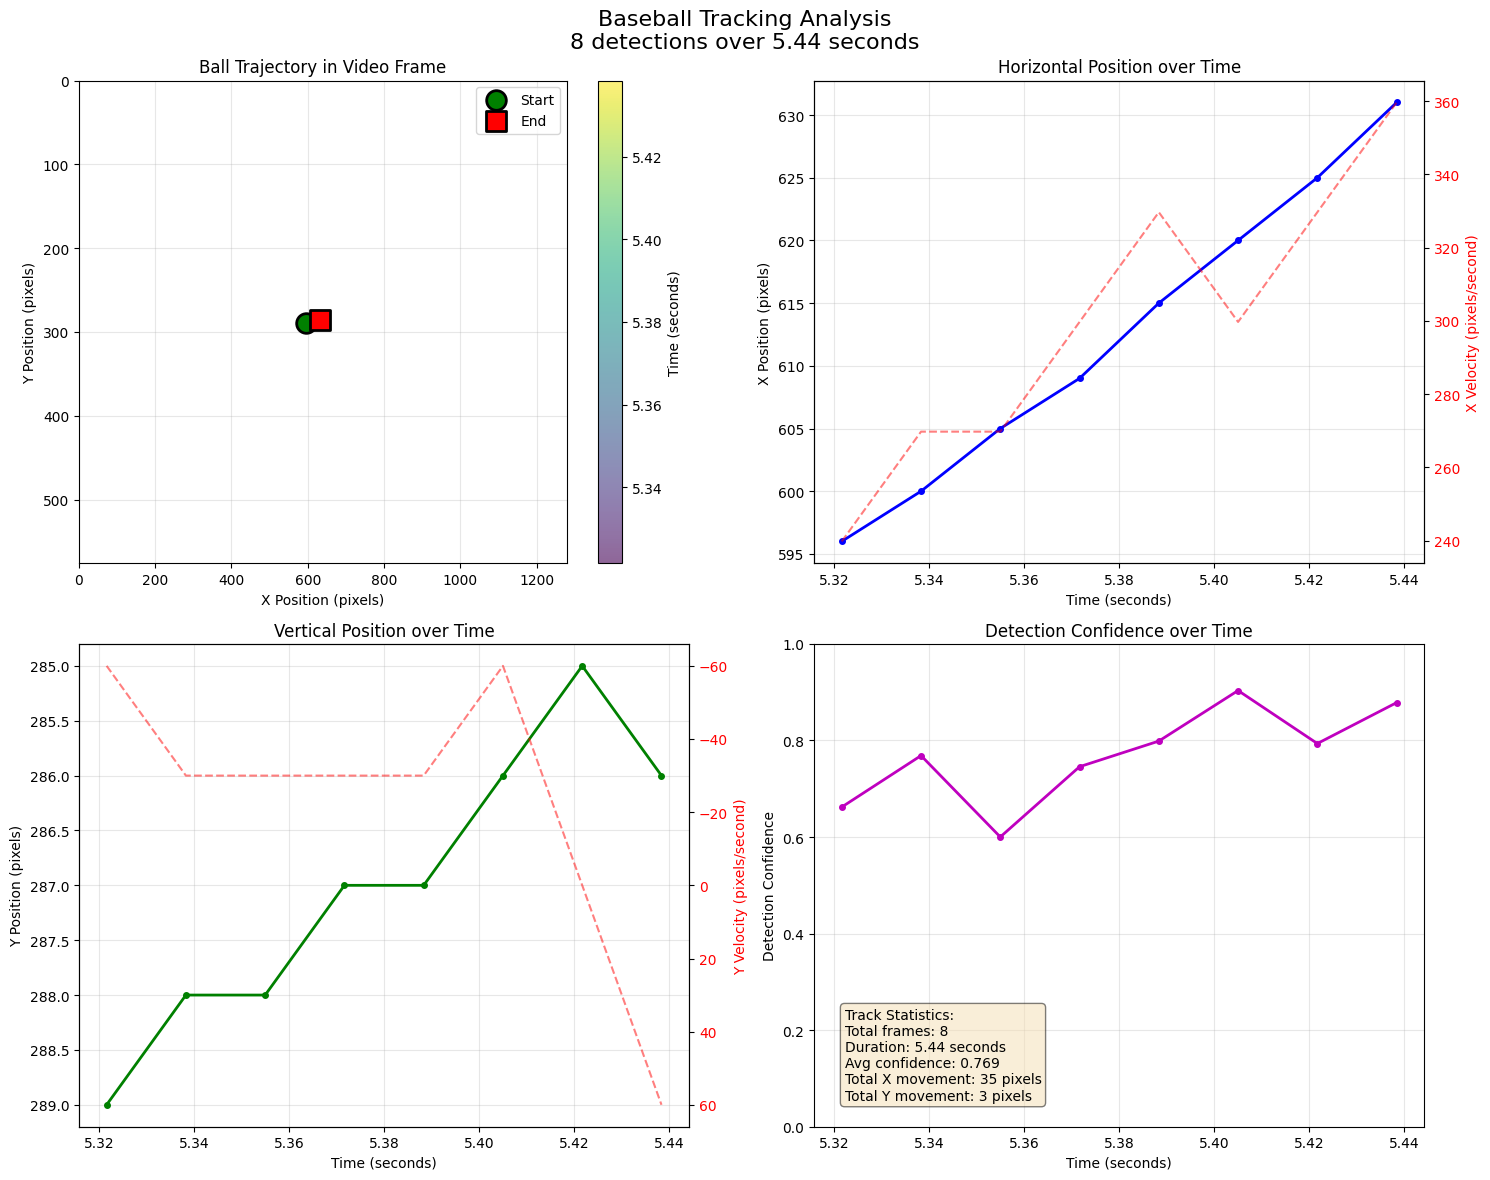

In [ ]:

  input_path = "/content/QZ58YNVF0P7Q.mp4"
  output_path = "tracked_baseball_output.mp4"
  plot_path = "baseball_trajectory.png"

  tracker, all_detections = process_video_with_tracking(
      input_path=input_path,
      model=model,
      device=device,
      output_path=output_path,
      save_plot=True,
      plot_path=plot_path
  )